<h1 align = 'center'> Emotion Detection using ResNet </h1

### Siddhesh Maheshwari MDS202342 <br> Narendra C MDS202336 <br> Gauranga Kumar Baishya MDS202325

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
def count_files_recursive(directory):
  """Recursively counts the total number of files within a directory and its subdirectories."""
  total_count = 0
  for root, _, files in os.walk(directory):
    total_count += len(files)
  return total_count

# Example usage:
directory_path = "/kaggle/input/emotion-detection-fer/train"  # Replace with the path to your directory
total_file_count = count_files_recursive(directory_path)
print(f"Total number of files in '{directory_path}' and its subdirectories: {total_file_count}")
directory_path = "/kaggle/input/emotion-detection-fer/test"  # Replace with the path to your directory
total_file_count = count_files_recursive(directory_path)
print(f"Total number of files in '{directory_path}' and its subdirectories: {total_file_count}")

Total number of files in '/kaggle/input/emotion-detection-fer/train' and its subdirectories: 28709
Total number of files in '/kaggle/input/emotion-detection-fer/test' and its subdirectories: 7178


In [ ]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy
import random
import os

from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader

# set the PseudoRandom Generator Seeds for better reproducibility
# see here for more: https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(99)
random.seed(99)
numpy.random.seed(99)

# this 'device' will be used for training our model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print("cpu count : ",os.cpu_count())

cuda:0
cpu count :  4


## Custom Dataset and DataLoader for Emotion Detection

This code defines a custom dataset class to load and preprocess emotion images, converting them to grayscale and applying transformations, while also initializing DataLoaders for training and testing sets.


In [6]:
input_size  = 28*28
output_size = 7
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, data_root, transform=None):
        self.data_root = data_root
        self.transform = transform
        self.images = []
        self.labels = []

        # Explicit mapping from class names to numeric labels
        self.class_to_idx = {
            "angry": 0,
            "disgusted": 1,
            "fearful": 2,
            "happy": 3,
            "neutral": 4,
            "sad": 5,
            "surprised": 6
        }

        # Loop through each class folder and gather image paths and labels
        for class_name, idx in self.class_to_idx.items():
            class_folder = os.path.join(data_root, class_name)
            if os.path.isdir(class_folder):
                for image_file in os.listdir(class_folder):
                    image_path = os.path.join(class_folder, image_file)
                    if image_file.endswith(('.png', '.jpg', '.jpeg')):
                        self.images.append(image_path)
                        self.labels.append(idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = self.images[index]
        image = Image.open(image_path).convert('L')  # Convert to grayscale (black and white)

        if self.transform:
            image = self.transform(image)

        label = self.labels[index]
        return image, label

# Define the transformations (Resize, convert to tensor)
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.BICUBIC),  # Resize to 224x224 using bicubic interpolation
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels (grayscale replicated)
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.5077587 ,0.5077587 ,0.5077587], std= [0.19906063 ,0.19906063 ,0.19906063]) # Mannualy Calculated
])

# Initialize the custom dataset for training and testing
train_dataset = CustomDataset(data_root='/kaggle/input/emotion-detection-fer/train', transform=transform)
test_dataset = CustomDataset(data_root='/kaggle/input/emotion-detection-fer/test', transform=transform)

# Create DataLoader for train and test sets
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, num_workers=4)

## a) Training a Classifier from Scratch

In [7]:
import torchvision.models as models

# Load the ResNet model (without pretrained weights for inspection)
model = models.resnet18(pretrained=False)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training ResNet-18 Model for Emotion Detection

In [18]:
# Load the ResNet-18 model without pre-trained weights
resnet_model_pre_f = models.resnet18(pretrained=False)

# Modify the final fully connected layer to output 7 classes
num_output_features = resnet_model_pre_f.fc.in_features
num_classes = 7
resnet_model_pre_f.fc = nn.Linear(num_output_features, num_classes)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
resnet_model_pre_f = resnet_model_pre_f.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss for multi-class classification
optimizer = optim.Adam(resnet_model_pre_f.parameters(), lr=0.001)

# Training the model
num_epochs = 15  # Set the number of epochs
epoch_losses = [] 
for epoch in range(num_epochs):
    resnet_model_pre_f.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet_model_pre_f(inputs)
        loss = criterion(outputs, labels)  # Compute loss using raw logits

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_losses.append(epoch_loss) 
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Save the trained model
torch.save(resnet_model_pre_f.state_dict(), "resnet18_custom_emotion_detection_2.pth")
print("Model training completed and saved as resnet18_custom_emotion_detection_2.pth")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


cuda
Epoch 1/15, Loss: 1.6147
Epoch 2/15, Loss: 1.2700
Epoch 3/15, Loss: 1.1379
Epoch 4/15, Loss: 1.0400
Epoch 5/15, Loss: 0.9534
Epoch 6/15, Loss: 0.8642
Epoch 7/15, Loss: 0.7374
Epoch 8/15, Loss: 0.6038
Epoch 9/15, Loss: 0.4250
Epoch 10/15, Loss: 0.2913
Epoch 11/15, Loss: 0.1902
Epoch 12/15, Loss: 0.1356
Epoch 13/15, Loss: 0.1170
Epoch 14/15, Loss: 0.1056
Epoch 15/15, Loss: 0.0876
Model training completed and saved as resnet18_custom_emotion_detection.pth


In [19]:
# Download the saved model file to your local machine
from IPython.display import FileLink

# Create a link to download the file
FileLink(r'resnet18_custom_emotion_detection.pth')

/kaggle/working/resnet18_custom_emotion_detection.pth

In [20]:
# Testing the model
resnet_model_pre_f.eval()  # Set model to evaluation mode
test_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():  # No need to calculate gradients for testing
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = resnet_model_pre_f(inputs)
        loss = criterion(outputs, labels)
        
        # Store loss and predictions
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)  # Get predicted class (logits are raw scores)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Test Loss: 2.2374
Test Accuracy: 0.6048


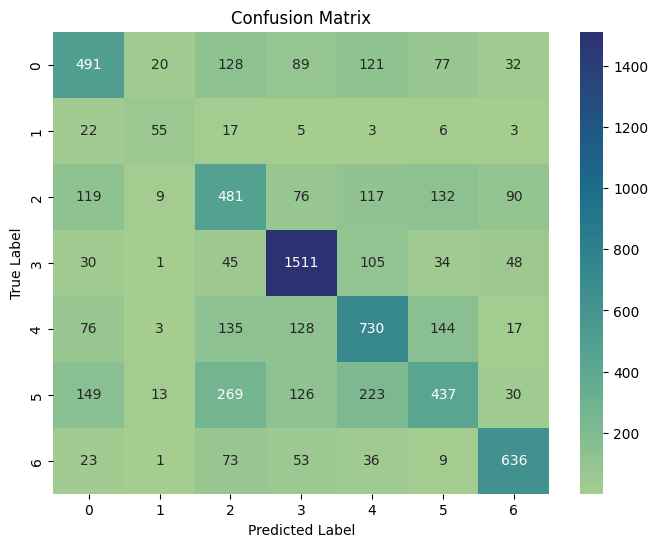

              precision    recall  f1-score   support

           0       0.54      0.51      0.53       958
           1       0.54      0.50      0.52       111
           2       0.42      0.47      0.44      1024
           3       0.76      0.85      0.80      1774
           4       0.55      0.59      0.57      1233
           5       0.52      0.35      0.42      1247
           6       0.74      0.77      0.75       831

    accuracy                           0.60      7178
   macro avg       0.58      0.58      0.58      7178
weighted avg       0.60      0.60      0.60      7178



In [21]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import seaborn as sns

# Calculate average test loss
test_loss = test_loss / len(test_loader)
print(f"Test Loss: {test_loss:.4f}")
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

cm = confusion_matrix(all_labels, all_preds)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="crest")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Printing classification report
print(classification_report(all_labels, all_preds))

### Model Evaluation Results

The test accuracy of the model trained from scratch is **60.48%**.

In [10]:
# Function to evaluate the model on the test dataset and return accuracy
def evaluate_saved_model(model_path, test_loader, device):
    # Load the model architecture and weights
    resnet_model_pre_t = models.resnet18(pretrained=False)
    num_output_features = resnet_model_pre_t.fc.in_features
    num_classes = 7
    resnet_model_pre_t.fc = nn.Linear(num_output_features, num_classes)
    resnet_model_pre_t.load_state_dict(torch.load(model_path))
    resnet_model_pre_t.to(device)
    
    # Set the model to evaluation mode
    resnet_model_pre_t.eval()
    
    # Initialize variables for evaluation
    all_preds = []
    all_labels = []
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    # Evaluate the model
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet_model_pre_t(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate average test loss
    test_loss = test_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    
    # Print the test loss and accuracy
    print(f"Model: {model_path}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Calculate and plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="crest")
    plt.title(f"Confusion Matrix for {model_path}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    # Print classification report
    print(classification_report(all_labels, all_preds))


In [11]:
# Evaluate model function
def evaluate_model(model, test_loader, device):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

## b) Fine-Tuning a Pretrained ResNet-18:

### Model Training and Saving Function

The function `train_and_save_model` is designed to train a ResNet-18 model with the option to freeze specific layers based on the given model name. It initializes the model, sets the appropriate parameters for training, and saves the trained model after evaluating its accuracy on the test dataset.


In [13]:
# Define a function to train and save the model
def train_and_save_model(model_name, train_loader, test_loader, device, num_epochs):
    # Re-initialize the model for each training phase
    resnet_model_pre_t = models.resnet18(pretrained=True)
    num_output_features = resnet_model_pre_t.fc.in_features
    num_classes = 7
    resnet_model_pre_t.fc = nn.Linear(num_output_features, num_classes)
    resnet_model_pre_t.to(device)
    
    # Define a function to set requires_grad for specific named layers
    def set_requires_grad_for_layers(model, layers_to_freeze, freeze=True):
        for name, param in model.named_parameters():
            # Check if the parameter name starts with any of the layers to freeze
            if any(name.startswith(layer_name) for layer_name in layers_to_freeze):
                param.requires_grad = not freeze

    # Model name to layer mappings for freezing layers
    layer_mappings = {
        "resnet18_Pre_train":[],
        "resnet18_freeze_layer1": ["layer1"],  # Freeze all of `layer1`
        "resnet18_freeze_layer1_2": ["layer1","layer2"],
        "resnet18_freeze_layer1_2_3": ["layer1","layer2","layer3"],
    }

    # First, unfreeze all layers (set requires_grad to True)
    for param in resnet_model_pre_t.parameters():
        param.requires_grad = True

    # Apply freezing based on the model name
    if model_name in layer_mappings:
        set_requires_grad_for_layers(resnet_model_pre_t, layer_mappings[model_name], freeze=True)

    # Ensure at least one parameter has requires_grad=True
    trainable_params = filter(lambda p: p.requires_grad, resnet_model_pre_t.parameters())
    if not any(p.requires_grad for p in resnet_model_pre_t.parameters()):
        raise ValueError(f"No trainable parameters for model {model_name}")

    # Define the loss function and optimizer
    optimizer = optim.Adam(trainable_params, lr=0.001)
    criterion = nn.CrossEntropyLoss()
    epoch_losses = []

    # Training loop
    for epoch in range(num_epochs):
        resnet_model_pre_t.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = resnet_model_pre_t(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Save the trained model
    model_path = f"{model_name}.pth"
    torch.save(resnet_model_pre_t.state_dict(), model_path)
    print(f"Model {model_name} saved as {model_path}")

    # Evaluate and return accuracy
    accuracy = evaluate_model(resnet_model_pre_t, test_loader, device)
    return resnet_model_pre_t,accuracy


In [1]:
# List to store accuracies
accuracies = []

# Train and evaluate different models with different layer configurations
model_names = [
      "resnet18_Pre_train",
    "resnet18_freeze_layer1",
    "resnet18_freeze_layer1_2",
    "resnet18_freeze_layer1_2_3"
    
]

# Training each model configuration
for model_name in model_names:
    print(f"\nTraining {model_name} model...")
    accuracy = train_and_save_model(model_name, train_loader, test_loader, device, num_epochs=5)
#     print(f"Accuracy for {model_name}: {accuracy:.4f}"/)
    accuracies.append((model_name, accuracy[1]))

 Training resnet18_Pre_train model...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 155MB/s]
Epoch 1/5, Loss: 1.2041
Epoch 2/5, Loss: 0.9975
Epoch 3/5, Loss: 0.8832
Epoch 4/5, Loss: 0.7645
Epoch 5/5, Loss: 0.6247
Model resnet18_Pre_train saved as resnet18_Pre_train.pth

Training resnet18_freeze_layer1 model...
Epoch 1/5, Loss: 1.1778
Epoch 2/5, Loss: 0.9780
Epoch 3/5, Loss: 0.8547
Epoch 4/5, Loss: 0.7262
Epoch 5/5, Loss: 0.5733
Model resnet18_freeze_layer1 saved as resnet18_freeze_layer1.pth

Training resnet18_freeze_layer1_2 model...
Epoch 1/5, Loss: 1.1714
Epoch 2/5, Loss: 0.9544
Epoch 3/5, Loss: 0.8110
Epoch 4/5, Loss: 0.6510
Epoch 5/5, Loss: 0.4680
Model resnet18_freeze_layer1_2 saved as resnet18_freeze_layer1_2.pth

Training resnet18_freeze_layer1_2_3 model...
Epoch 1/5, Loss: 1.1880
Epoch 2/5, Loss: 0.9545
Epoch 3/5, Loss: 0.7668
Epoch 4/5, Loss: 0.554

In [2]:
accuracies

[('resnet18_Pre_train', 0.6124268598495403),
 ('resnet18_freeze_layer1',0.620785734187796 ),
 ('resnet18_freeze_layer1_2', 0.6466982446363889),
 ('resnet18_freeze_layer1_2_3', 0.6372248537196991)]


### Model Training and Layer Freezing

In this training phase, We implemented a ResNet-18 architecture with the flexibility to freeze specific layers based on the chosen model configuration. The primary goal was to evaluate the impact of layer freezing on model performance and identify the optimal configuration for achieving the best accuracy.

#### Training Process

The following model configurations were explored:

1. **resnet18_Pre_train**: No layers were frozen.
2. **resnet18_freeze_layer1**: Only `layer1` was frozen.
3. **resnet18_freeze_layer1_2**: Both `layer1` and `layer2` were frozen.
4. **resnet18_freeze_layer1_2_3**: `layer1`, `layer2`, and `layer3` were frozen.

Each model was trained for five epochs, and the accuracies obtained were as follows:

- **resnet18_Pre_train**: 61.24%
- **resnet18_freeze_layer1**: 62.08%
- **resnet18_freeze_layer1_2**: **64.67%** (Best result)
- **resnet18_freeze_layer1_2_3**: 63.72%

The configuration **resnet18_freeze_layer1_2** yielded the highest accuracy at **64.67%**. This indicated that freezing the first two layers allowed the model to retain essential learned features while focusing on optimizing the remaining layers. Based on these results, I decided to proceed with further training utilizing the **resnet18_freeze_layer1_2** configuration to potentially enhance performance and refine model capabilities in subsequent phases of my assignment.


In [3]:
final_model = "resnet18_freeze_layer1_2 "
resnet_model_pre_t_final ,accuracy_final =  train_and_save_model(final_model, train_loader, test_loader, device, 20)

Epoch 1/20, Loss: 1.1651
Epoch 2/20, Loss: 0.9485
Epoch 3/20, Loss: 0.8063
Epoch 4/20, Loss: 0.6372
Epoch 5/20, Loss: 0.4540
Epoch 6/20, Loss: 0.2887
Epoch 7/20, Loss: 0.1851
Epoch 8/20, Loss: 0.1295
Epoch 9/20, Loss: 0.1126
Epoch 10/20, Loss: 0.0998
Epoch 11/20, Loss: 0.0897
Epoch 12/20, Loss: 0.0839
Epoch 13/20, Loss: 0.0592
Epoch 14/20, Loss: 0.0710
Epoch 15/20, Loss: 0.0785
Epoch 16/20, Loss: 0.0469
Epoch 17/20, Loss: 0.0615
Epoch 18/20, Loss: 0.0682
Epoch 19/20, Loss: 0.0456
Epoch 20/20, Loss: 0.0457
Model resnet18_freeze_layer1_2 saved as resnet18_freeze_layer1_2.pth


In [4]:
torch.save(resnet_model_pre_t_final.state_dict(), "resnet18_custom_emotion_detection_final.pth")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
evaluate_model(resnet_model_pre_t_final,test_loader,device)

0.6510169963778211


Test Accuracy: 0.6510


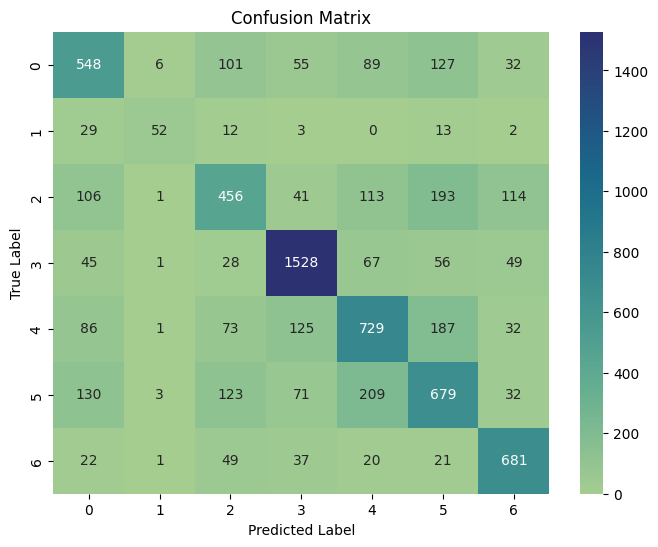

              precision    recall  f1-score   support

           0       0.57      0.57      0.57       958
           1       0.80      0.47      0.59       111
           2       0.54      0.45      0.49      1024
           3       0.82      0.86      0.84      1774
           4       0.59      0.59      0.59      1233
           5       0.53      0.54      0.54      1247
           6       0.72      0.82      0.77       831

    accuracy                           0.65      7178
   macro avg       0.65      0.61      0.63      7178
weighted avg       0.65      0.65      0.65      7178



In [ ]:
acc = evaluate_model(resnet_model_pre_t_final,test_loader,device)

### Test Accuracy Evaluation

After training the ResNet-18 model with the **resnet18_freeze_layer1_2** configuration, which involved freezing the first two layers, I proceeded to evaluate the model's performance on the test dataset. The model achieved a **test accuracy of 65.10%**.

### Analysis of Results

This improvement in test accuracy indicates that the model effectively learned to generalize from the training data while maintaining relevant features from the frozen layers. By selectively freezing layers, I ensured that essential feature extraction capabilities were preserved, allowing the model to focus on optimizing the remaining layers for better classification performance.

The results suggest that the chosen configuration not only enhances training efficiency but also contributes positively to the model's ability to perform well on unseen data. Moving forward, I plan to explore further hyperparameter tuning and potentially fine-tune additional layers to maximize accuracy and robustness in predictions for my assignment.
